In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


In [31]:
with open('tickets.pickle','rb') as read_file:
    data = pickle.load(read_file)
with open('mvp.pickle','rb') as read_file:
    mvp = pickle.load(read_file) 
with open('violation.pickle','rb') as read_file:
    mvp_viol = pickle.load(read_file)

In [32]:
data.head()

,issue_date,license_plate_state,license_plate_type,unit_description,fine_level1_amount,notice_level,hearing_disposition,ticket_queue,time_passed,hearing_outcome,...,violation_0976170,violation_0976180,violation_0976210,violation_0976220,violation_0980080,violation_0980110,violation_0980120,violation_0980130,violation_0980220,violation_1141115
0,2001-03-02 18:50:00,IL,PAS,CPD,50,<NA>,zero,1,6.0,0,...,0,0,0,0,0,0,0,0,0,0
1,2000-09-21 21:45:00,TN,PAS,CPD,30,<NA>,zero,0,6.0,0,...,0,0,0,0,0,0,0,0,0,0
2,1999-10-08 07:57:00,IL,PAS,DOF,30,<NA>,zero,1,1189.0,0,...,0,0,0,0,0,0,0,0,0,0
3,2000-09-21 21:18:00,IA,PAS,CPD,30,<NA>,zero,0,6.0,0,...,0,0,0,0,0,0,0,0,0,0
4,2000-09-21 21:20:00,KY,PAS,CPD,50,<NA>,Not Liable,0,399.0,Not Liable,...,0,0,0,0,0,0,0,0,0,0


In [5]:
mvpV_train, mvpV_test = train_test_split(mvp_viol, test_size=0.2, random_state=42)

In [7]:
from sklearn.linear_model import LogisticRegression

lm_V = LogisticRegression(solver='newton-cg', C=100000) 
lm_V.fit(mvpV_train.drop(columns=['ticket_queue'], mvpV_train['ticket_queue'])

SyntaxError: unexpected EOF while parsing (<ipython-input-7-86698245b509>, line 5)

In [43]:
mvp_train, mvp_test = train_test_split(mvp, test_size=0.2, random_state=42)

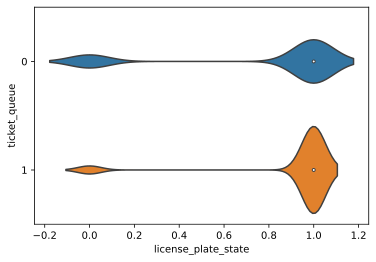

In [44]:
sns.violinplot(x='license_plate_state',
               y='ticket_queue',
               data=mvp_train);

In [12]:
lm_V = LogisticRegression(solver='newton-cg', C=100000) 
lm_V.fit(mvpV_train.drop(columns=['ticket_queue']), mvpV_train['ticket_queue'])

LogisticRegression(C=100000, solver='newton-cg')

In [13]:
viol_eval = mvpV_test.copy()
viol_eval['pred'] = lm_V.predict(mvpV_test.drop(columns=['ticket_queue']))
viol_eval.loc[:, 'pred'] = viol_eval['pred'].astype('category')
viol_eval['correct_pred'] = viol_eval['pred'] == viol_eval['ticket_queue']

In [16]:
# sns.stripplot(data=viol_eval,
#               x='',
#               y='pred',
#               hue='correct_pred',
#               palette={False: '#f03b20', True: '#3182bd'});

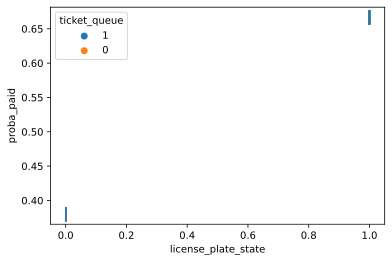

In [48]:
# This is the same model but with proba (returns probabilities instead of class)
# mvp_eval['proba_paid'] = lm_1.predict_proba(mvp_eval[['license_plate_state']])[:, 1]

# sns.scatterplot(data=mvp_eval,
#                 x='license_plate_state',
#                 y='proba_paid',
#                 hue='ticket_queue',
#                 marker='|',
#                 s=200);

In [18]:
cf_matrix = confusion_matrix(viol_eval['ticket_queue'], viol_eval['pred'])
cf_matrix

array([[ 150,  677],
       [ 106, 1067]], dtype=int64)

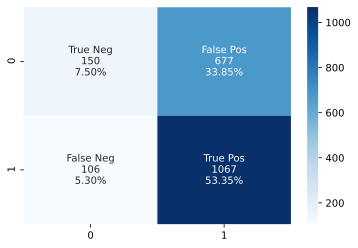

In [19]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

In [20]:
viol_eval['ticket_queue'].astype('int32').dtypes
viol_eval['ticket_queue'].value_counts()

1    1173
0     827
Name: ticket_queue, dtype: int64

In [90]:
lm_V.predict_proba(viol_eval[['license_plate_state']])[:5]

array([[0.33291637, 0.66708363],
       [0.33291637, 0.66708363],
       [0.33291637, 0.66708363],
       [0.33291637, 0.66708363],
       [0.62030904, 0.37969096]])

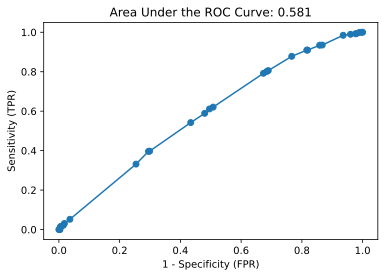

In [24]:
def plot_roc(true, probas):
    auc = roc_auc_score(true, probas)
    plt.plot(fpr, tpr, marker='o')
    plt.xlabel('1 - Specificity (FPR)')
    plt.ylabel('Sensitivity (TPR)');
    plt.title(f"Area Under the ROC Curve: {round(auc, 3)}");
    
viol_eval['proba_pay'] = lm_V.predict_proba(viol_eval.drop(columns=['ticket_queue','pred','correct_pred']))[:, 1]
fpr, tpr, thresholds = roc_curve(viol_eval['ticket_queue'],viol_eval['proba_pay'],pos_label='1')


plot_roc(viol_eval['ticket_queue'], viol_eval['proba_pay'])

In [25]:
mask = tpr > 0.9
thresholds[mask].max()


0.507142856230712

## Multiple features: Logistic Regression

In [54]:
with open('mvp2.pickle','rb') as read_file:
    mvp2 = pickle.load(read_file)
mvp2_train, mvp2_test = train_test_split(mvp2, test_size=0.2, random_state=42)

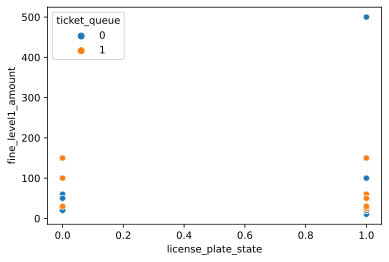

In [55]:
sns.scatterplot(data=mvp2_train,
                x='license_plate_state',
                y='fine_level1_amount',
                hue='ticket_queue');

In [56]:
features = ['license_plate_state', 'fine_level1_amount']

# Since we're using more than one feature, let's scale our features
scaler = StandardScaler()
X_train = scaler.fit_transform(mvp2_train[features])
y_train = mvp2_train['ticket_queue']

In [57]:
lm_2 = LogisticRegression() 
lm_2.fit(X_train, y_train)

LogisticRegression()

In [62]:
cf_matrix2 = confusion_matrix(mvp2_test['ticket_queue'], preds)
cf_matrix2

array([[118, 504],
       [ 80, 924]], dtype=int64)

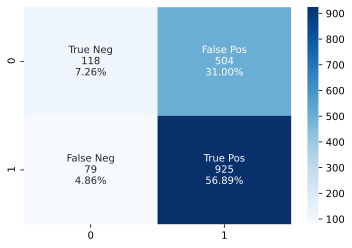

In [60]:
X_test = scaler.transform(mvp2_test[features])
preds = lm_2.predict(X_test)

cf_matrix2 = confusion_matrix(mvp2_test['ticket_queue'], preds)


group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix2, annot=labels, fmt='', cmap='Blues');

In [ ]:
fpr, tpr, thresholds = roc_curve(mvp2_eval['in_sf'],
                                 df_eval['proba_sf'])
